## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('bitcoin.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Close')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Open'].values.reshape(-1, 1)

df

,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940
...,...
2022-05-28,28.6201
2022-05-29,29.0271
2022-05-30,29.4652


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Open'] = arima_sc.fit_transform(df_close)
df_scaled

,Open
Date,
2020-06-01,-1.566754
2020-06-02,-1.522736
2020-06-03,-1.562419
2020-06-04,-1.554036
2020-06-05,-1.546455
...,...
2022-05-28,-0.420844
2022-05-29,-0.396509
2022-05-30,-0.370315


# Vẽ đồ thị

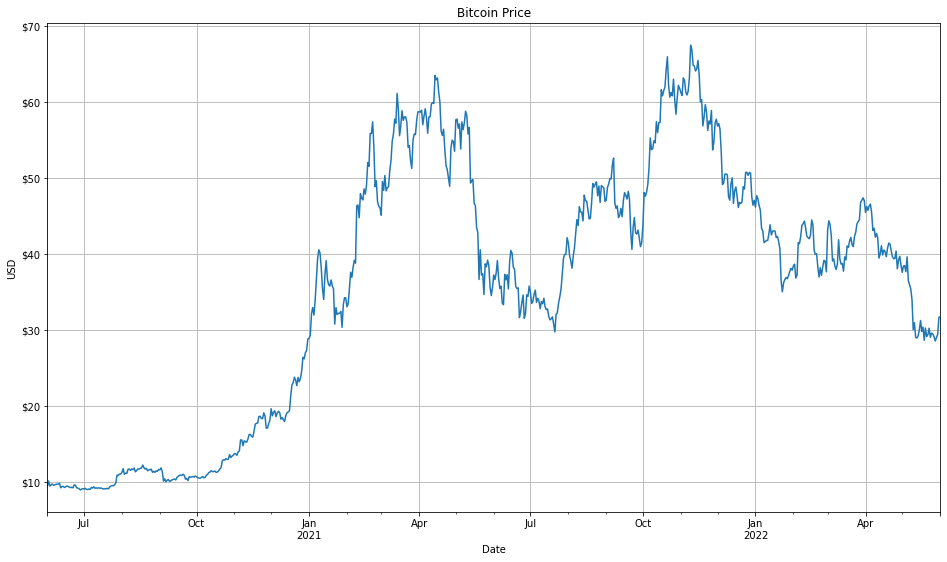

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.8)], df_scaled[(int)(len(df_scaled) * 0.8):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.8):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (584, 1)
test shape:  (147, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['Open'],'Bitcoin Price')

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.387117
p-value                     0.588436
Number of lags used         0.000000
Number of observations    583.000000
critical value (1%)        -3.441616
critical value (5%)        -2.866510
critical value (10%)       -2.569417
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

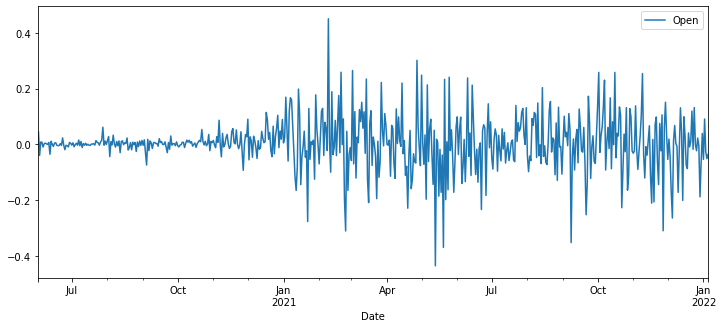

In [8]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Bitcoin Price First Difference
ADF test statistic        -25.272028
p-value                     0.000000
Number of lags used         0.000000
Number of observations    582.000000
critical value (1%)        -3.441636
critical value (5%)        -2.866519
critical value (10%)       -2.569422
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1113.586, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1120.309, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1119.660, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1119.683, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1121.357, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1117.694, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.191 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 561.678
Date:                Sun, 26 Jun 2022   AIC                          -1121.357
Time:                        23:46:32   BIC                          -1116.988
Sample:                             0   HQIC                         -1119.654
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0085      0.000     27.875      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):               279.92
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):              21.26   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(test))
pred


array([0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208, 0.6083208,
       0.6083208, 0.6083208, 0.6083208, 0.6083208, 

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

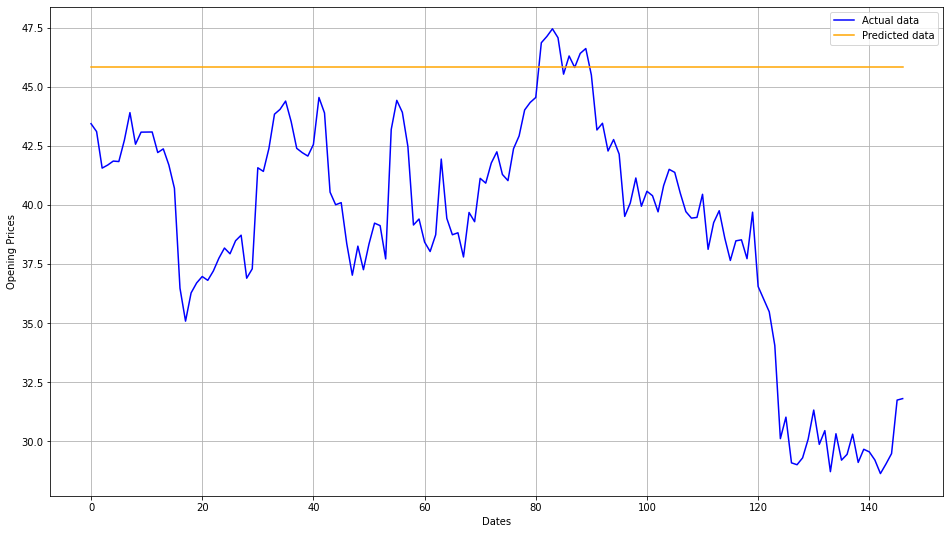

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 6.79
MAPE: 19.35%
MSE: 68.03
RMSE: 8.25
R2: -1.94


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2022-01-06,43.4316,45.8331,-2.4015
2022-01-07,43.0979,45.8331,-2.7352
2022-01-08,41.5513,45.8331,-4.2818
2022-01-09,41.6812,45.8331,-4.1519
2022-01-10,41.8489,45.8331,-3.9842
...,...,...,...
2022-05-28,28.6201,45.8331,-17.2130
2022-05-29,29.0271,45.8331,-16.8060
2022-05-30,29.4652,45.8331,-16.3679


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2022-01-06,43.4316,45.8331,-2.4015
2022-01-07,43.0979,45.8331,-2.7352
2022-01-08,41.5513,45.8331,-4.2818
2022-01-09,41.6812,45.8331,-4.1519
2022-01-10,41.8489,45.8331,-3.9842
...,...,...,...
2022-05-28,28.6201,45.8331,-17.2130
2022-05-29,29.0271,45.8331,-16.8060
2022-05-30,29.4652,45.8331,-16.3679


# Vẽ đồ thị thể hiện sai số

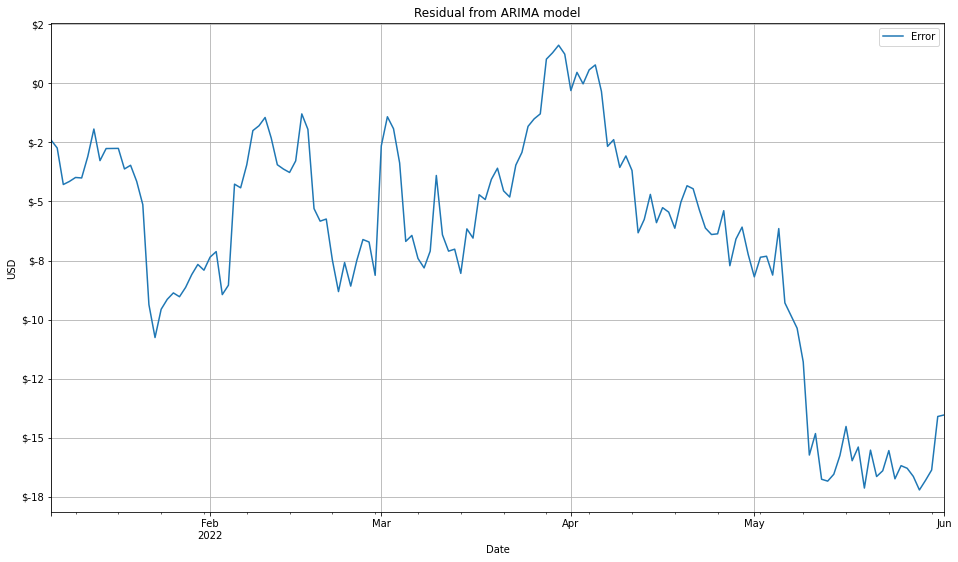

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[ -2.4015],
       [ -2.7352],
       [ -4.2818],
       [ -4.1519],
       [ -3.9842],
       [ -4.004 ],
       [ -3.0981],
       [ -1.9331],
       [ -3.2709],
       [ -2.7595],
       [ -2.7539],
       [ -2.7526],
       [ -3.6232],
       [ -3.4678],
       [ -4.1495],
       [ -5.135 ],
       [ -9.3654],
       [-10.7602],
       [ -9.5645],
       [ -9.1418],
       [ -8.8708],
       [ -9.033 ],
       [ -8.6375],
       [ -8.0966],
       [ -7.6656],
       [ -7.9093],
       [ -7.3575],
       [ -7.1219],
       [ -8.9429],
       [ -8.5453],
       [ -4.2666],
       [ -4.4212],
       [ -3.4479],
       [ -1.9992],
       [ -1.7949],
       [ -1.4442],
       [ -2.3138],
       [ -3.4447],
       [ -3.6276],
       [ -3.772 ],
       [ -3.2828],
       [ -1.2922],
       [ -1.9476],
       [ -5.3006],
       [ -5.833 ],
       [ -5.7435],
       [ -7.4781],
       [ -8.8148],
       [ -7.5849],
       [ -8.5829],
       [ -7.4939],
       [ -6.6115],
       [ -6.

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (144, 3, 1)
y_train (144, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin_8_2.h5")

Epoch 1/300
5/5 [==============================] - 2s 5ms/step - loss: 67.7202
Epoch 2/300
5/5 [==============================] - 0s 6ms/step - loss: 65.0693
Epoch 3/300
5/5 [==============================] - 0s 6ms/step - loss: 62.0089
Epoch 4/300
5/5 [==============================] - 0s 6ms/step - loss: 56.4691
Epoch 5/300
5/5 [==============================] - 0s 6ms/step - loss: 47.3118
Epoch 6/300
5/5 [==============================] - 0s 8ms/step - loss: 29.7832
Epoch 7/300
5/5 [==============================] - 0s 6ms/step - loss: 13.3109
Epoch 8/300
5/5 [==============================] - 0s 7ms/step - loss: 13.1037
Epoch 9/300
5/5 [==============================] - 0s 7ms/step - loss: 12.4157
Epoch 10/300
5/5 [==============================] - 0s 6ms/step - loss: 8.7629
Epoch 11/300
5/5 [==============================] - 0s 5ms/step - loss: 8.7198
Epoch 12/300
5/5 [==============================] - 0s 6ms/step - loss: 7.9615
Epoch 13/300
5/5 [==============================] - 

In [22]:
model = load_model("bitcoin_8_2.h5")
error_pred = model.predict(x_train)
error_pred

5/5 [==============================] - 0s 2ms/step


array([[ -5.0116286 ],
       [ -4.205816  ],
       [ -3.8632216 ],
       [ -3.9354537 ],
       [ -2.8120987 ],
       [ -1.8229654 ],
       [ -4.223696  ],
       [ -2.6877604 ],
       [ -3.0746028 ],
       [ -3.041722  ],
       [ -4.202792  ],
       [ -3.4222496 ],
       [ -4.4773674 ],
       [ -5.4092307 ],
       [ -9.658636  ],
       [ -9.973732  ],
       [ -9.952898  ],
       [ -9.513789  ],
       [ -9.121442  ],
       [ -9.157815  ],
       [ -8.826379  ],
       [ -8.30655   ],
       [ -7.795366  ],
       [ -7.8937564 ],
       [ -7.3545566 ],
       [ -7.1667767 ],
       [ -8.616316  ],
       [ -8.288847  ],
       [ -4.9768376 ],
       [ -3.6893184 ],
       [ -3.2120144 ],
       [ -1.7877432 ],
       [ -2.2701998 ],
       [ -1.490695  ],
       [ -3.1045516 ],
       [ -4.2743464 ],
       [ -3.7337673 ],
       [ -3.7923996 ],
       [ -3.0763233 ],
       [ -1.0339857 ],
       [ -3.6798148 ],
       [ -5.832176  ],
       [ -6.095866  ],
       [ -5

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2022-01-06,43.4316,45.8331,-2.4015,-5.011629
2022-01-07,43.0979,45.8331,-2.7352,-4.205816
2022-01-08,41.5513,45.8331,-4.2818,-3.863222
2022-01-09,41.6812,45.8331,-4.1519,-3.935454
2022-01-10,41.8489,45.8331,-3.9842,-2.812099
...,...,...,...,...
2022-05-25,29.6487,45.8331,-16.1844,-16.415159
2022-05-26,29.5379,45.8331,-16.2952,-16.832458
2022-05-27,29.1940,45.8331,-16.6391,-16.626873


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2022-01-06,43.4316,45.8331,-2.4015,-5.011629,40.821471
2022-01-07,43.0979,45.8331,-2.7352,-4.205816,41.627284
2022-01-08,41.5513,45.8331,-4.2818,-3.863222,41.969878
2022-01-09,41.6812,45.8331,-4.1519,-3.935454,41.897646
2022-01-10,41.8489,45.8331,-3.9842,-2.812099,43.021001
...,...,...,...,...,...
2022-05-25,29.6487,45.8331,-16.1844,-16.415159,29.417941
2022-05-26,29.5379,45.8331,-16.2952,-16.832458,29.000642
2022-05-27,29.1940,45.8331,-16.6391,-16.626873,29.206227


# Vẽ đồ thị

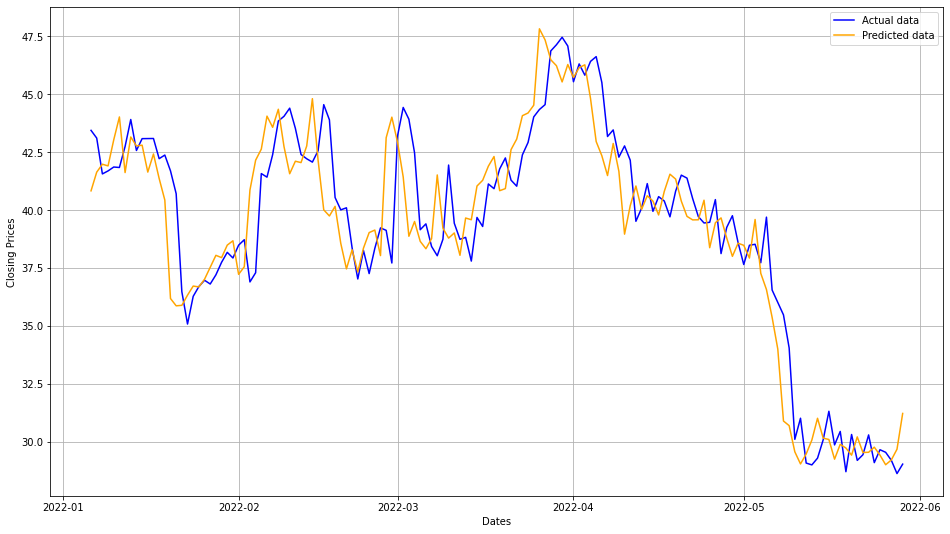

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1.40
MAPE: 3.55%
MSE: 3.61
RMSE: 1.90
R2: 0.84


# Lấy 3 ngày cuối ra để dự báo

In [27]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -16.6391
2022-05-28   -17.2130
2022-05-29   -16.8060
Name: Error, dtype: float64

# Đưa về ma trận

In [28]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-16.6391],
        [-17.213 ],
        [-16.806 ]]])

In [29]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 29ms/step


array([-16.626873], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [30]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,29.0271,45.8331,-16.806


In [31]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,29.0271,45.8331,-16.806,29.206227


# Ghi ra file csv

In [32]:
df.to_csv("btc_processed_data_8_2.csv")
df_scaled.to_csv("btc_scaled_data_8_2.csv")
df_pred.to_csv("btc_ARIMA-PRED_8_2.csv")
df_lstm.to_csv("btc_LSTM_PRED_8_2.csv")
y_arima.to_csv("btc_Forecast_8_2.csv")